In [2]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, brier_score_loss, roc_curve, auc
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

print("=" * 80)
print("STARTING ELEC872 PIPELINE (3-CELL VERSION)")
print("=" * 80)

try:
    df_raw = pd.read_csv("cardio_train.csv", sep=";")
    print(f"Data Loaded Successfully: {len(df_raw):,} records")
except FileNotFoundError:
    raise FileNotFoundError("cardio_train.csv not found. Upload it to Colab then re-run.")

def clinical_metrics(y_true, y_pred, y_prob=None):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    denom_spec = (tn + fp)
    denom_fpr = (fp + tn)
    denom_fnr = (fn + tp)
    denom_all = (tn + fp + fn + tp)

    specificity = (tn / denom_spec) if denom_spec else 0.0
    fpr_ = (fp / denom_fpr) if denom_fpr else 0.0
    fnr_ = (fn / denom_fnr) if denom_fnr else 0.0
    sel_rate = ((tp + fp) / denom_all) if denom_all else 0.0

    auc_ = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    brier = brier_score_loss(y_true, y_prob) if y_prob is not None else np.nan

    return {
        "acc": acc,
        "auc": auc_,
        "precision": prec,
        "recall_tpr": rec,
        "specificity": specificity,
        "f1": f1,
        "fpr": fpr_,
        "fnr": fnr_,
        "selection_rate": sel_rate,
        "brier": brier,
        "cm": (tn, fp, fn, tp),
    }

print("\nPHASE 1: PRE-PROCESSING ABLATION STUDY")

X_raw = df_raw.drop(["id", "cardio"], axis=1, errors="ignore")
y_raw = df_raw["cardio"]

base_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
base_score = cross_val_score(base_model, X_raw, y_raw, cv=3, scoring="accuracy").mean()
print(f"   [1] Baseline (Raw Data):           Accuracy {base_score:.4f}")

df_clean = df_raw.copy()
df_clean["age_years"] = (df_clean["age"] / 365.25).round(1)

bp_mask = (
    (df_clean["ap_hi"] >= 60) & (df_clean["ap_hi"] <= 240) &
    (df_clean["ap_lo"] >= 30) & (df_clean["ap_lo"] <= 150) &
    (df_clean["ap_lo"] < df_clean["ap_hi"])
)
df_clean = df_clean[bp_mask].copy()

X_clean = df_clean.drop(["id", "cardio", "age_years"], axis=1, errors="ignore")
y_clean = df_clean["cardio"]

clean_score = cross_val_score(base_model, X_clean, y_clean, cv=3, scoring="accuracy").mean()
print(f"   [2] After Cleaning:                Accuracy {clean_score:.4f} (Imp: {(clean_score-base_score)*100:+.2f}%)")

df_eng = df_clean.copy()
df_eng["bmi"] = df_eng["weight"] / ((df_eng["height"] / 100) ** 2)
df_eng["pulse_pressure"] = df_eng["ap_hi"] - df_eng["ap_lo"]

features = [
    "age_years", "gender", "height", "weight", "ap_hi", "ap_lo",
    "cholesterol", "gluc", "smoke", "alco", "active", "bmi", "pulse_pressure"
]

X_eng = df_eng[features]
y_eng = df_eng["cardio"]

eng_score = cross_val_score(base_model, X_eng, y_eng, cv=3, scoring="accuracy").mean()
print(f"   [3] After Feature Engineering:     Accuracy {eng_score:.4f} (Imp: {(eng_score-clean_score)*100:+.2f}%)")

ablation_results = {"Raw": base_score, "Cleaned": clean_score, "Engineered": eng_score}

print("\nPHASE 2: MULTI-MODEL COMPARISON + TUNING")

X_train, X_test, y_train, y_test = train_test_split(
    X_eng, y_eng, test_size=0.2, random_state=42, stratify=y_eng
)

models_config = {
    "Logistic Regression": {
        "pipe": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(random_state=42, max_iter=3000))
        ]),
        "params": {"clf__C": [0.1, 1, 10]}
    },
    "Random Forest": {
        "pipe": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
        ]),
        "params": {"clf__n_estimators": [100, 200], "clf__max_depth": [10, 15, None]}
    },
    "Gradient Boosting": {
        "pipe": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", GradientBoostingClassifier(random_state=42))
        ]),
        "params": {"clf__n_estimators": [100, 200], "clf__learning_rate": [0.05, 0.1]}
    }
}

results = {}
best_auc = -1
best_model_name = None
best_pipe = None
best_params = None

print(f"   {'Model':<20} | {'Acc':<8} | {'AUC':<8} | {'Status'}")
print("-" * 65)

for model_name, cfg in models_config.items():
    gs = GridSearchCV(cfg["pipe"], cfg["params"], cv=3, scoring="roc_auc", n_jobs=-1)
    gs.fit(X_train, y_train)

    tuned_pipe = gs.best_estimator_
    yhat = tuned_pipe.predict(X_test)
    yhat_p = tuned_pipe.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, yhat)
    auc_ = roc_auc_score(y_test, yhat_p)

    results[model_name] = {"accuracy": acc, "auc": auc_, "best_params": gs.best_params_}

    print(f"   {model_name:<20} | {acc:.4f}   | {auc_:.4f}   | Tuned")

    if auc_ > best_auc:
        best_auc = auc_
        best_pipe = tuned_pipe
        best_model_name = model_name
        best_params = gs.best_params_

print("-" * 65)
print(f"BEST MODEL SELECTED: {best_model_name} (AUC: {best_auc:.4f})")
print("Best Params:", best_params)

scaler = best_pipe.named_steps["scaler"]
best_clf_template = best_pipe.named_steps["clf"]

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

clf_params = best_clf_template.get_params()
clf_best = type(best_clf_template)(**clf_params)

try:
    cal_model = CalibratedClassifierCV(estimator=clf_best, method="sigmoid", cv=3)
except TypeError:
    cal_model = CalibratedClassifierCV(base_estimator=clf_best, method="sigmoid", cv=3)

cal_model.fit(X_train_scaled, y_train)
model = cal_model

explain_model = type(best_clf_template)(**clf_params)
explain_model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

final_metrics = clinical_metrics(y_test, y_pred, y_prob)

cal_prob_true, cal_prob_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="uniform")
roc_fpr, roc_tpr, _ = roc_curve(y_test, y_prob)
roc_auc_value = auc(roc_fpr, roc_tpr)
cmatrix = confusion_matrix(y_test, y_pred, labels=[0, 1])

print("\nFINAL TEST METRICS (Calibrated Risk Scores)")
tn, fp, fn, tp = final_metrics["cm"]
print(f"   Accuracy:    {final_metrics['acc']:.4f}")
print(f"   ROC-AUC:     {final_metrics['auc']:.4f}")
print(f"   Precision:   {final_metrics['precision']:.4f}")
print(f"   Recall/TPR:  {final_metrics['recall_tpr']:.4f}")
print(f"   Specificity: {final_metrics['specificity']:.4f}")
print(f"   F1:          {final_metrics['f1']:.4f}")
print(f"   Brier:       {final_metrics['brier']:.4f}")
print(f"   Confusion:   TN={tn}, FP={fp}, FN={fn}, TP={tp}")

print("\nPHASE 3: RESPONSIBLE AI FAIRNESS AUDIT (Gender)")

audit_df = pd.DataFrame({
    "Actual": y_test.values,
    "Prob": y_prob,
    "Pred": y_pred,
    "Gender_Raw": df_eng.loc[X_test.index, "gender"].values
})

rep_f = clinical_metrics(
    audit_df[audit_df["Gender_Raw"] == 1]["Actual"],
    audit_df[audit_df["Gender_Raw"] == 1]["Pred"],
    audit_df[audit_df["Gender_Raw"] == 1]["Prob"]
)
rep_m = clinical_metrics(
    audit_df[audit_df["Gender_Raw"] == 2]["Actual"],
    audit_df[audit_df["Gender_Raw"] == 2]["Pred"],
    audit_df[audit_df["Gender_Raw"] == 2]["Prob"]
)

fairness = {"Women": rep_f, "Men": rep_m}

eq_odds_gap = max(
    abs(rep_f["recall_tpr"] - rep_m["recall_tpr"]),
    abs(rep_f["fpr"] - rep_m["fpr"])
)

print(f"   Women Acc={rep_f['acc']:.3f}, AUC={rep_f['auc']:.3f}, TPR={rep_f['recall_tpr']:.3f}, FPR={rep_f['fpr']:.3f}, FNR={rep_f['fnr']:.3f}")
print(f"   Men   Acc={rep_m['acc']:.3f}, AUC={rep_m['auc']:.3f}, TPR={rep_m['recall_tpr']:.3f}, FPR={rep_m['fpr']:.3f}, FNR={rep_m['fnr']:.3f}")
print(f"   Equalized-Odds Gap (max(|ΔTPR|, |ΔFPR|)): {eq_odds_gap:.3f}")

explainability = {"type": best_model_name}
if best_model_name == "Logistic Regression":
    explainability["values"] = explain_model.coef_.ravel()
else:
    explainability["values"] = explain_model.feature_importances_ if hasattr(explain_model, "feature_importances_") else None

print("\nCELL 1 COMPLETE.")
print("Next: Run CELL 2 for visualizations, then CELL 3 for the interactive system.")



STARTING ELEC872 PIPELINE (3-CELL VERSION)
Data Loaded Successfully: 70,000 records

PHASE 1: PRE-PROCESSING ABLATION STUDY
   [1] Baseline (Raw Data):           Accuracy 0.7157
   [2] After Cleaning:                Accuracy 0.7135 (Imp: -0.22%)
   [3] After Feature Engineering:     Accuracy 0.7125 (Imp: -0.10%)

PHASE 2: MULTI-MODEL COMPARISON + TUNING
   Model                | Acc      | AUC      | Status
-----------------------------------------------------------------
   Logistic Regression  | 0.7278   | 0.7909   | Tuned
   Random Forest        | 0.7334   | 0.8011   | Tuned
   Gradient Boosting    | 0.7360   | 0.8021   | Tuned
-----------------------------------------------------------------
BEST MODEL SELECTED: Gradient Boosting (AUC: 0.8021)
Best Params: {'clf__learning_rate': 0.05, 'clf__n_estimators': 200}

FINAL TEST METRICS (Calibrated Risk Scores)
   Accuracy:    0.7364
   ROC-AUC:     0.8020
   Precision:   0.7547
   Recall/TPR:  0.6921
   Specificity: 0.7797
   F1:        

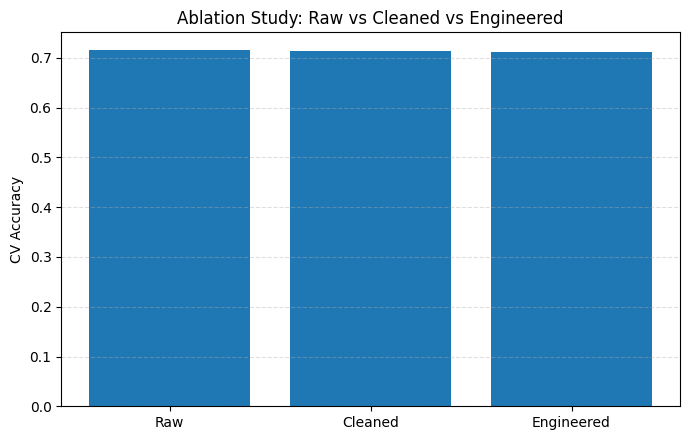

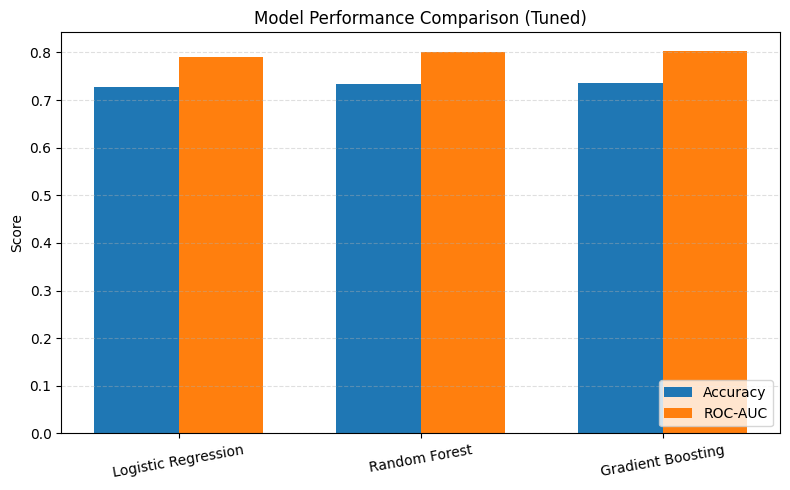

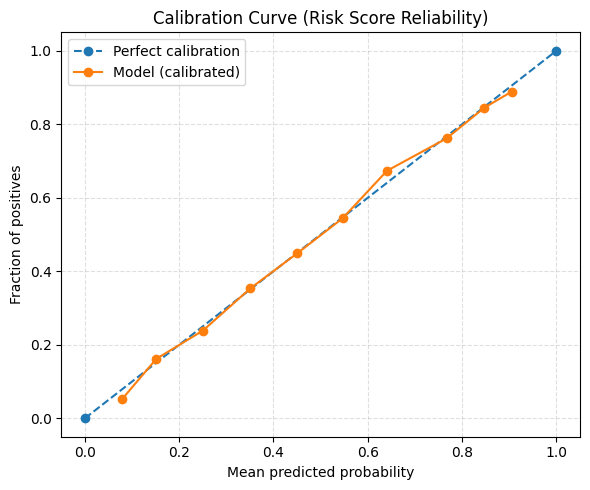

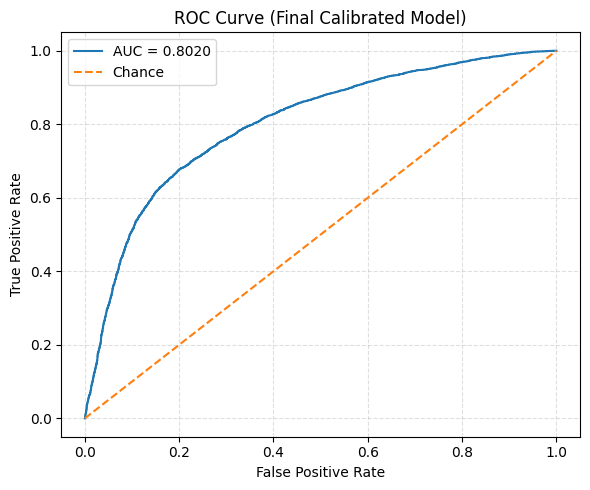

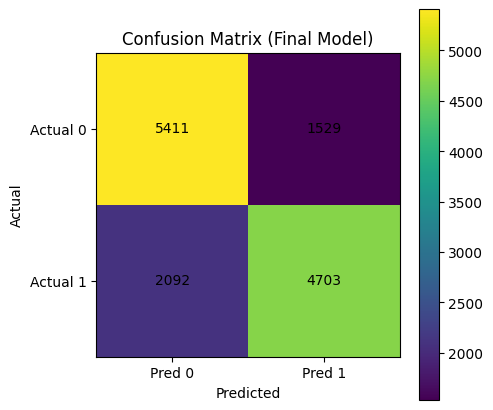

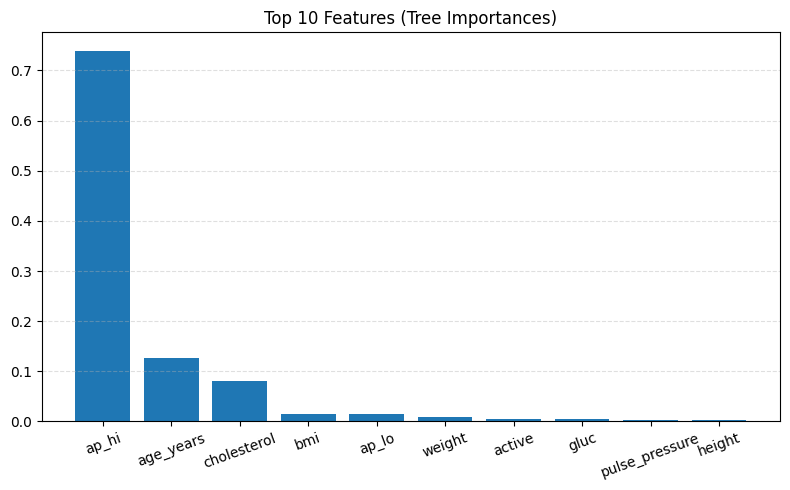

CELL 2 COMPLETE.


In [3]:

import numpy as np
import matplotlib.pyplot as plt

needed_globals = [
    "ablation_results", "results", "final_metrics",
    "cal_prob_true", "cal_prob_pred",
    "roc_fpr", "roc_tpr", "roc_auc_value",
    "cmatrix", "features", "explainability"
]
missing = [name for name in needed_globals if name not in globals()]
if missing:
    raise RuntimeError(f"Run Cell 1 first. Missing: {missing}")

plt.figure(figsize=(7, 4.5))
plt.bar(list(ablation_results.keys()), list(ablation_results.values()))
plt.ylabel("CV Accuracy")
plt.title("Ablation Study: Raw vs Cleaned vs Engineered")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

names = list(results.keys())
accs = [results[n]["accuracy"] for n in names]
aucs = [results[n]["auc"] for n in names]

x = np.arange(len(names))
width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, accs, width, label="Accuracy")
plt.bar(x + width/2, aucs, width, label="ROC-AUC")
plt.xticks(x, names, rotation=10)
plt.ylabel("Score")
plt.title("Model Performance Comparison (Tuned)")
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot([0, 1], [0, 1], linestyle="--", marker="o", label="Perfect calibration")
plt.plot(cal_prob_pred, cal_prob_true, marker="o", label="Model (calibrated)")
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve (Risk Score Reliability)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 5))
plt.plot(roc_fpr, roc_tpr, label=f"AUC = {roc_auc_value:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Final Calibrated Model)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4.5))
plt.imshow(cmatrix)
plt.title("Confusion Matrix (Final Model)")
plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["Actual 0", "Actual 1"])
for (i, j), val in np.ndenumerate(cmatrix):
    plt.text(j, i, str(val), ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.tight_layout()
plt.show()

vals = explainability["values"]
etype = explainability["type"]

if vals is None:
    print("No explainability values available for this model.")
else:
    vals = np.array(vals)
    if etype == "Logistic Regression":
        top_idx = np.argsort(np.abs(vals))[::-1][:10]
    else:
        top_idx = np.argsort(vals)[::-1][:10]

    top_feats = [features[i] for i in top_idx]
    top_vals = vals[top_idx]

    plt.figure(figsize=(8, 5))
    plt.bar(top_feats, top_vals)
    plt.title("Top 10 Features (" + ("LR Coefficients" if etype == "Logistic Regression" else "Tree Importances") + ")")
    plt.xticks(rotation=20)
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

print("CELL 2 COMPLETE.")



In [4]:
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

needed = ["df_eng", "features", "scaler", "model"]
missing = [k for k in needed if k not in globals()]
if missing:
    raise RuntimeError(f"Run Cell 1 first. Missing: {missing}")

has_explain = ("explain_model" in globals()) and ("best_model_name" in globals())

style = {'description_width': '150px'}
layout = widgets.Layout(width='320px')

w_age = widgets.IntText(value=50, description='Age (Years):', style=style, layout=layout)
w_gender = widgets.Dropdown(options=[('Female', 1), ('Male', 2)], value=1, description='Gender:', style=style, layout=layout)

w_height = widgets.IntText(value=165, description='Height (cm):', style=style, layout=layout)
w_weight = widgets.FloatText(value=70.0, description='Weight (kg):', style=style, layout=layout)

w_ap_hi = widgets.IntText(value=120, description='Systolic BP:', style=style, layout=layout)
w_ap_lo = widgets.IntText(value=80, description='Diastolic BP:', style=style, layout=layout)

w_chol = widgets.Dropdown(options=[('Normal', 1), ('Above Normal', 2), ('Well Above Normal', 3)], value=1, description='Cholesterol:', style=style, layout=layout)
w_gluc = widgets.Dropdown(options=[('Normal', 1), ('Above Normal', 2), ('Well Above Normal', 3)], value=1, description='Glucose:', style=style, layout=layout)

w_smoke = widgets.Checkbox(value=False, description='Smoker?')
w_alco = widgets.Checkbox(value=False, description='Alcohol Consumer?')
w_active = widgets.Checkbox(value=True, description='Physically Active?')

w_research = widgets.Checkbox(value=False, description='For Researchers (show technical details)')

button_calc = widgets.Button(
    description="Analyze Risk (Smart Advisor)",
    button_style='primary',
    layout=widgets.Layout(width='320px')
)
output_area = widgets.Output()

EXPECTED_IMPROVEMENTS = {
    'quit_smoking': 0.12,
    'reduce_alcohol': 0.05,
    'start_exercise': 0.15,
    'lower_cholesterol': 0.10,
    'lower_glucose': 0.10
}

def validate_medical_inputs(age, height, weight, ap_hi, ap_lo):
    errors, warns = [], []

    if ap_hi <= ap_lo:
        errors.append(f"INVALID BP: Systolic ({ap_hi}) must be > Diastolic ({ap_lo}).")
    if ap_hi < 70 or ap_hi > 240:
        errors.append(f"INVALID SYSTOLIC BP: {ap_hi} outside [70, 240].")
    if ap_lo < 40 or ap_lo > 150:
        errors.append(f"INVALID DIASTOLIC BP: {ap_lo} outside [40, 150].")

    if age < 18 or age > 100:
        warns.append("Age outside 18–100; model may be less reliable.")
    if height < 120 or height > 220:
        warns.append("Height looks unusual; check entry.")
    if weight < 35 or weight > 250:
        warns.append("Weight looks unusual; check entry.")

    bmi = weight / ((height/100)**2) if height > 0 else 0
    if bmi < 12 or bmi > 60:
        warns.append(f"Extreme BMI ({bmi:.1f}); check height/weight.")

    return (False, errors, warns) if errors else (True, [], warns)

def get_peer_stats(age, gender):
    age_min, age_max = age - 2, age + 2
    peers = df_eng[
        (df_eng["age_years"] >= age_min) &
        (df_eng["age_years"] <= age_max) &
        (df_eng["gender"] == gender)
    ]
    if len(peers) == 0:
        return None, 0, age_min, age_max
    return peers["cardio"].mean(), len(peers), age_min, age_max

def calculate_improvement_smart(base_prob, current_input, feature_index, target_value, intervention_type):
    modified = current_input.copy()
    modified[0, feature_index] = target_value

    new_prob = model.predict_proba(scaler.transform(modified))[0][1]
    model_delta = base_prob - new_prob

    if model_delta < 0 and intervention_type in EXPECTED_IMPROVEMENTS:
        lit_change = base_prob * EXPECTED_IMPROVEMENTS[intervention_type]
        return lit_change, new_prob, "Medical Literature (Safety Override)", model_delta

    return max(0.0, model_delta), new_prob, "AI Model (Calibrated)", model_delta

def build_research_why_lines(raw_input):
    lines = []
    if not has_explain:
        lines.append("   Explainability model not available.")
        return lines

    if best_model_name == "Logistic Regression":
        x_scaled = scaler.transform(raw_input)[0]
        coefs = explain_model.coef_.ravel()
        contrib = coefs * x_scaled
        top = np.argsort(np.abs(contrib))[::-1][:8]
        lines.append("   WHY (LR approx contributions):")
        for i in top:
            direction = "increases" if contrib[i] > 0 else "decreases"
            lines.append(f"     - {features[i]}: contrib={contrib[i]: .3f} ({direction} risk)")
        lines.append("   Note: LR contributions are approximate, standardized-units.")
    else:
        if hasattr(explain_model, "feature_importances_"):
            imps = explain_model.feature_importances_
            top = np.argsort(imps)[::-1][:8]
            lines.append("   WHY (Tree global feature importances):")
            for i in top:
                lines.append(f"     - {features[i]}: importance={imps[i]:.4f}")
            lines.append("   Note: Tree importances are global (not personalized).")
        else:
            lines.append("   No feature importances available for this model.")

    return lines

def on_button_click(b):
    with output_area:
        clear_output()

        ok, errs, warns = validate_medical_inputs(
            w_age.value, w_height.value, w_weight.value, w_ap_hi.value, w_ap_lo.value
        )
        if not ok:
            print("INPUT VALIDATION ERROR")
            for e in errs:
                print(e)
            return

        if warns:
            print("WARNINGS:")
            for w in warns:
                print("  " + w)
            print("-" * 65)

        bmi = w_weight.value / ((w_height.value / 100) ** 2)
        pulse = w_ap_hi.value - w_ap_lo.value

        raw_input = np.array([[
            w_age.value, w_gender.value, w_height.value, w_weight.value,
            w_ap_hi.value, w_ap_lo.value,
            w_chol.value, w_gluc.value,
            1 if w_smoke.value else 0,
            1 if w_alco.value else 0,
            1 if w_active.value else 0,
            bmi, pulse
        ]])

        prob = model.predict_proba(scaler.transform(raw_input))[0][1]
        peer_avg, peer_n, a_min, a_max = get_peer_stats(w_age.value, w_gender.value)

        print("=" * 65)
        print("SMART CARDIO-ADVISOR SYSTEM (Educational Prototype)")
        print("=" * 65)
        print(f"YOUR RISK (calibrated): {prob:.1%}")
        print(f"RISK CATEGORY:         {'ELEVATED' if prob > 0.5 else 'LOWER'}")

        if peer_avg is not None:
            status = "higher" if prob > peer_avg else "lower"
            print(
                f"PEER COMPARISON: Among similar people in the dataset, about {peer_avg:.1%} had cardiovascular disease; "
                f"your predicted risk is {status} than that group average."
            )

        print("-" * 65)
        print("PERSONALIZED INTERVENTIONS")
        print("-" * 65)

        researcher_lines = []
        interventions_debug = []

        total_reduction = 0.0
        advice_count = 0

        def patient_intervention_line(label, change):
            print(f"{label:<24} | Risk -{change:.1%}")

        def add_debug(label, change, src, model_delta, new_prob):
            interventions_debug.append({
                "label": label,
                "change": change,
                "src": src,
                "model_delta": model_delta,
                "new_prob": new_prob
            })

        if w_smoke.value:
            ch, new_p, src, model_delta = calculate_improvement_smart(prob, raw_input, 8, 0, "quit_smoking")
            patient_intervention_line("QUIT SMOKING", ch)
            add_debug("QUIT SMOKING", ch, src, model_delta, new_p)
            total_reduction += ch
            advice_count += 1

        if w_alco.value:
            ch, new_p, src, model_delta = calculate_improvement_smart(prob, raw_input, 9, 0, "reduce_alcohol")
            patient_intervention_line("REDUCE ALCOHOL", ch)
            add_debug("REDUCE ALCOHOL", ch, src, model_delta, new_p)
            total_reduction += ch
            advice_count += 1

        if w_active.value is False:
            ch, new_p, src, model_delta = calculate_improvement_smart(prob, raw_input, 10, 1, "start_exercise")
            patient_intervention_line("START EXERCISE", ch)
            add_debug("START EXERCISE", ch, src, model_delta, new_p)
            total_reduction += ch
            advice_count += 1

        if w_chol.value > 1:
            ch, new_p, src, model_delta = calculate_improvement_smart(prob, raw_input, 6, 1, "lower_cholesterol")
            patient_intervention_line("LOWER CHOLESTEROL", ch)
            add_debug("LOWER CHOLESTEROL", ch, src, model_delta, new_p)
            total_reduction += ch
            advice_count += 1

        if w_gluc.value > 1:
            ch, new_p, src, model_delta = calculate_improvement_smart(prob, raw_input, 7, 1, "lower_glucose")
            patient_intervention_line("LOWER GLUCOSE", ch)
            add_debug("LOWER GLUCOSE", ch, src, model_delta, new_p)
            total_reduction += ch
            advice_count += 1

        bmi_floor = 18.5
        min_safe_weight = bmi_floor * ((w_height.value / 100) ** 2)

        if bmi > 25:
            print(f"\nWEIGHT OPTIMIZATION (BMI {bmi:.1f})")
            best_reduction, best_kg, best_new_prob = 0.0, None, None

            for kg in range(1, 21):
                new_w = w_weight.value - kg
                if new_w < min_safe_weight:
                    break

                temp = raw_input.copy()
                temp[0, 3] = new_w
                temp[0, 11] = new_w / ((w_height.value / 100) ** 2)

                p_new = model.predict_proba(scaler.transform(temp))[0][1]
                red = prob - p_new

                if red > best_reduction:
                    best_reduction, best_kg, best_new_prob = red, kg, p_new

                if red >= 0.05:
                    print(f"Target: Lose {kg} kg (New BMI {temp[0,11]:.1f}) for ≥5% risk reduction")
                    break

            if best_kg is not None and best_reduction > 0:
                print(f"Best option: Lose {best_kg} kg (Estimated Risk -{best_reduction:.1%})")
                total_reduction += best_reduction
                advice_count += 1
                if w_research.value:
                    researcher_lines.append(
                        f"Weight optimization: best_kg={best_kg}, model_delta={best_reduction:+.3%}, new_prob={best_new_prob:.3%}, bmi_floor={bmi_floor}"
                    )
            else:
                print("No safe weight-loss target improved predicted risk in this model.")
                if w_research.value:
                    researcher_lines.append(
                        f"Weight optimization: no improvement within kg<=20 and BMI floor {bmi_floor} (min_safe_weight={min_safe_weight:.2f})"
                    )

        print("-" * 65)
        if advice_count > 0:
            final_risk = max(0.01, prob - total_reduction)
            print("POTENTIAL IMPROVEMENT (Educational estimate)")
            print(f"   Current Risk:    {prob:.1%}")
            print(f"   Total Reduction: -{total_reduction:.1%}")
            print(f"   New Estimate:    {final_risk:.1%}")
        else:
            final_risk = prob
            print("No major modifiable factors flagged by this prototype at current inputs.")

        print("=" * 65)
        print("DISCLAIMER: Educational prototype. Not medical advice.")
        print("=" * 65)

        if w_research.value:
            print("\n" + "=" * 65)
            print("FOR RESEARCHERS (Technical Details)")
            print("=" * 65)

            if "best_model_name" in globals():
                print(f"Model: {best_model_name} (probabilities calibrated: sigmoid)")
            else:
                print("Model: (unknown name) (probabilities calibrated: sigmoid)")

            print(f"Input engineered: BMI={bmi:.2f}, PulsePressure={pulse:.1f}")

            if peer_avg is not None:
                print(f"Peer group definition: age in [{a_min:.1f}, {a_max:.1f}] and gender={w_gender.value}")
                print(f"Peer group size: n={peer_n}")
            else:
                print("Peer group: n=0 (no matches)")

            print(f"Raw risk prob: {prob:.4f} | Final estimate after interventions: {final_risk:.4f}")

            print("\nIntervention debug:")
            if len(interventions_debug) == 0:
                print("  No interventions triggered.")
            else:
                for d in interventions_debug:
                    print(
                        f"  - {d['label']}: applied_change={d['change']:.3%} | "
                        f"Source={d['src']} | ModelDelta={d['model_delta']:+.3%} | NewProb={d['new_prob']:.3%}"
                    )

            if researcher_lines:
                print("\nOther notes:")
                for line in researcher_lines:
                    print("  - " + line)

            for line in build_research_why_lines(raw_input):
                print(line)

            print("=" * 65)

button_calc.on_click(on_button_click)

ui = widgets.VBox([
    widgets.HTML("<h3>Patient Vitals</h3>"),
    w_age, w_gender, w_height, w_weight,

    widgets.HTML("<h3>Blood Pressure</h3>"),
    w_ap_hi, w_ap_lo,

    widgets.HTML("<h3>Lab Results</h3>"),
    w_chol, w_gluc,

    widgets.HTML("<h3>Lifestyle</h3>"),
    w_smoke, w_alco, w_active,

    widgets.HTML("<h3>For Researchers</h3>"),
    w_research,

    widgets.HTML("<br>"),
    button_calc
])

display(ui, output_area)


Output()